In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *


/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)
n_rct_before_split = 10**4
n_host = 200
n_mirror = 500
n_cand2 = 500
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 3
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * T + 1* X[:,0]*T + -1* X[:,1]*T + eps 
std_true_y = 0.01 # Standard deviation for the true Y

X0 = np.random.randint(0, 2, size= n_rct_before_split)
X1 = np.random.normal(size=n_rct_before_split)
x_distributions= {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + 2*X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 2*X_1 + eps)

In [3]:
X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, n_mirror, power_x, power_x_t, outcome_function, std_true_y)

pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2, \
                                    power_x, power_x_t, outcome_function, std_true_y)

X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

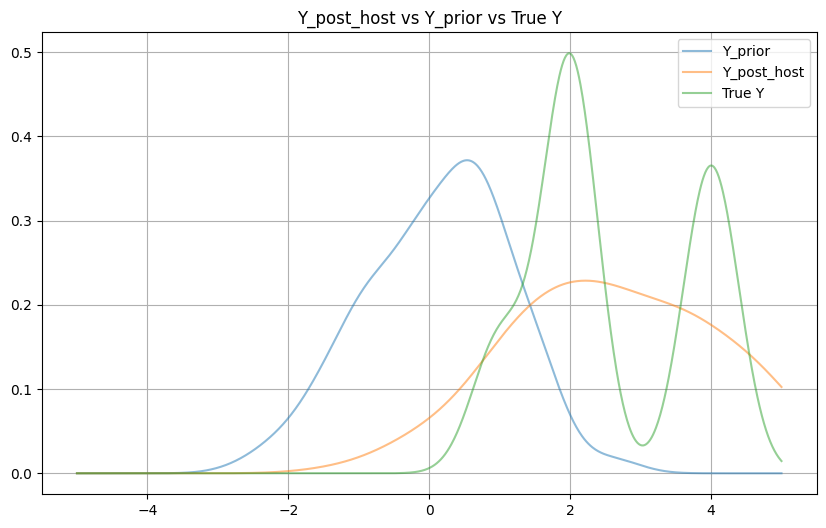

In [4]:
# Initialize prior parameters
post_mean = np.array([0,0 , 0, 0, 0, 0])
beta_0, sigma_0_sq,inv_cov_0 = post_mean, sigma_rand_error**2,1/sigma_prior*np.eye(len(post_mean)) 
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(np.array(X_host.values), np.array(Y_host.values))

# Generate Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_rand_error, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


In [36]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 40
m_samples_for_expectation = 1000
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 10
max_tree_depth = 7
sigma_rand_error = sigma_0_sq

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 40050/40050 [08:15, 80.84it/s, step size=6.32e-02, acc. prob=0.872] 


Inference ran for 8.26 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      2.00      0.12      2.00      1.80      2.20  22727.28      1.00
    beta_1     -1.00      0.21     -1.00     -1.35     -0.65  14937.93      1.00
    beta_2      0.00      0.09      0.00     -0.14      0.15  37529.15      1.00
    beta_3      1.96      0.16      1.96      1.69      2.23  19585.52      1.00
    beta_4     -0.93      0.29     -0.93     -1.41     -0.46  12164.65      1.00
    beta_5     -0.00      0.13     -0.00     -0.21      0.22  38084.54      1.00

Number of divergences: 0


### 3. Calculating EIG observational

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [37]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [39]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

4.8258680445997015

Now to calculate for the causal

In [40]:
sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func_mirror = lambda beta: beta @ (X_mirror).T

In [41]:
n_causal_outer_exp = 20
pred_in_causal_form_mirror = predictions_in_EIG_causal_form(pred_func_mirror, theta_samples=beta_post_host.values[:n_causal_outer_exp], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

Sample: 100%|██████████| 110/110 [00:00, 221.38it/s, step size=6.01e-02, acc. prob=0.921]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 229.52it/s, step size=6.05e-02, acc. prob=0.898]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 213.44it/s, step size=6.28e-02, acc. prob=0.916]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 228.94it/s, step size=6.05e-02, acc. prob=0.921]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 215.67it/s, step size=5.90e-02, acc. prob=0.914]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 215.97it/s, step size=6.05e-02, acc. prob=0.918]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 222.37it/s, step size=6.05e-02, acc. prob=0.915]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 379.19it/s, step size=1.01e-01, acc. prob=0.627]


Inference ran for 0.0 minutes


Sample: 100%|██████████| 110/110 [00:00, 256.39it/s, step size=6.02e-02, acc. prob=0.918]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 269.38it/s, step size=6.60e-02, acc. prob=0.908]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 224.28it/s, step size=6.05e-02, acc. prob=0.918]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 249.76it/s, step size=5.99e-02, acc. prob=0.929]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 249.11it/s, step size=6.36e-02, acc. prob=0.902]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 230.94it/s, step size=6.01e-02, acc. prob=0.893]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 331.35it/s, step size=9.55e-02, acc. prob=0.783]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 223.33it/s, step size=6.05e-02, acc. prob=0.920]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 259.19it/s, step size=6.05e-02, acc. prob=0.904]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 298.94it/s, step size=7.25e-02, acc. prob=0.855]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 227.15it/s, step size=6.05e-02, acc. prob=0.911]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 263.76it/s, step size=6.86e-02, acc. prob=0.888]

Inference ran for 0.01 minutes


In [42]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form_mirror, sigma_rand_error)

0.04427337581455504

Now, trying to calculate in closed form

In [22]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

3.650597845644657

In [23]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

1.0152111352954254

### For the cand2 dataset

In [24]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [25]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

8.896259861216322

In [26]:
pred_func_cand2 = lambda beta: beta @ (X_cand2).T
pred_in_causal_form_cand2 = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:n_causal_outer_exp], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

Sample: 100%|██████████| 110/110 [00:00, 242.86it/s, step size=6.62e-02, acc. prob=0.885]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 223.20it/s, step size=6.05e-02, acc. prob=0.903]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 212.93it/s, step size=5.48e-02, acc. prob=0.917]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 226.78it/s, step size=6.04e-02, acc. prob=0.905]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 250.48it/s, step size=6.86e-02, acc. prob=0.860]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 248.28it/s, step size=6.05e-02, acc. prob=0.926]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 211.08it/s, step size=6.00e-02, acc. prob=0.925]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 203.20it/s, step size=5.16e-02, acc. prob=0.924]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 230.43it/s, step size=6.36e-02, acc. prob=0.901]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 212.90it/s, step size=5.36e-02, acc. prob=0.935]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 220.23it/s, step size=6.22e-02, acc. prob=0.910]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 317.89it/s, step size=7.19e-02, acc. prob=0.888]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 216.09it/s, step size=5.59e-02, acc. prob=0.926]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 300.19it/s, step size=7.85e-02, acc. prob=0.844]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 252.94it/s, step size=6.23e-02, acc. prob=0.904]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 286.60it/s, step size=8.68e-02, acc. prob=0.795]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 187.48it/s, step size=5.92e-02, acc. prob=0.908]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 242.74it/s, step size=5.74e-02, acc. prob=0.904]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 303.30it/s, step size=7.84e-02, acc. prob=0.798]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 200.03it/s, step size=5.34e-02, acc. prob=0.929]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 184.57it/s, step size=6.05e-02, acc. prob=0.919]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 233.01it/s, step size=5.76e-02, acc. prob=0.914]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 309.53it/s, step size=8.93e-02, acc. prob=0.777]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 192.17it/s, step size=5.22e-02, acc. prob=0.928]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 213.74it/s, step size=5.87e-02, acc. prob=0.908]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 243.28it/s, step size=6.05e-02, acc. prob=0.922]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 226.13it/s, step size=6.03e-02, acc. prob=0.919]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 277.97it/s, step size=8.34e-02, acc. prob=0.795]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 201.84it/s, step size=5.52e-02, acc. prob=0.915]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 295.90it/s, step size=8.05e-02, acc. prob=0.844]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 306.73it/s, step size=8.47e-02, acc. prob=0.791]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 332.96it/s, step size=8.74e-02, acc. prob=0.797]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 299.34it/s, step size=7.51e-02, acc. prob=0.844]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 185.46it/s, step size=4.87e-02, acc. prob=0.942]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 219.65it/s, step size=5.96e-02, acc. prob=0.892]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 227.74it/s, step size=6.05e-02, acc. prob=0.909]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 343.39it/s, step size=8.53e-02, acc. prob=0.782]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 291.36it/s, step size=7.07e-02, acc. prob=0.866]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 254.20it/s, step size=6.36e-02, acc. prob=0.909]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 316.59it/s, step size=7.84e-02, acc. prob=0.824]

Inference ran for 0.01 minutes


In [27]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form_mirror, sigma_rand_error)

12.29252227193058

Now, trying to calculate in closed form

In [28]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

3.5246389076494964

In [29]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

0.9299762890346037

### Sanity Experiments

In [107]:
from scipy.stats import multivariate_normal

In [108]:
mvn = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host)

In [109]:
n_samples_for_expectation = 1000
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))

In [110]:
beta = mvn.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [111]:
beta.shape

(33000, 6)

In [112]:
sigma_rand_error = 1

In [113]:
y_pred_vec = predict_with_all_sampled_linear(pd.DataFrame(beta), X_mirror_arr)

In [114]:
y_pred_form = predictions_in_EIG_obs_form(y_pred_vec, n_samples_for_expectation, m_samples_for_expectation)

In [115]:
compute_EIG_obs_from_samples(y_pred_form, sigma_rand_error)

5.145915136298868

In [116]:
calc_posterior_predictive_entropy(y_pred_form, sigma_rand_error)

714.7857517598685

In [117]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

3.931592495904404

In [118]:
n_e = len(y_pred_form[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

713.4008590982407

In [119]:
beta_repeat = np.tile(beta_post_host_vec,(len(beta),1))

In [120]:
y_pred_vec_repeat = predict_with_all_sampled_linear(pd.DataFrame(beta_repeat), X_mirror_arr)

In [121]:
y_pred_vec.shape

(33000, 500)

In [122]:
y_pred_vec_repeat.shape

(33000, 500)

In [123]:
y_pred_form_repeat = predictions_in_EIG_obs_form(y_pred_vec_repeat, n_samples_for_expectation, m_samples_for_expectation)

In [124]:
cov_matrix_post_host_zero = np.zeros_like(cov_matrix_post_host)

In [125]:
sigma_repeat = 0.0001

In [126]:
compute_EIG_obs_from_samples(y_pred_form_repeat,  sigma_repeat)

0.3790444008527629

In [127]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_zero,sigma_repeat)

-9.094947017729282e-12

In [128]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_zero) @ X.T) + (sigma_repeat**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

-3895.700919385764

In [129]:
calc_posterior_predictive_entropy(y_pred_form_repeat, sigma_repeat)

-3895.295105206976

In [153]:
cov_matrix_post_host_id = np.eye(6)
mvn_id = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host_id)
n_samples_for_expectation = 500
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
beta_id = mvn_id.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [241]:
sigma_rand_error = 1

In [242]:
y_pred_vec_id = predict_with_all_sampled_linear(pd.DataFrame(beta_id), X_mirror_arr)
y_pred_form_id = predictions_in_EIG_obs_form(y_pred_vec_id, n_samples_for_expectation, m_samples_for_expectation)

In [243]:
compute_EIG_obs_from_samples(y_pred_form_id, sigma_rand_error,lower=True)

3.3510320938009954

In [244]:
compute_EIG_obs_from_samples_alt(y_pred_form_id, sigma_rand_error,lower=False)

337.87148284257427

In [245]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_id,sigma_rand_error)

15.125739714168185

Below calculates from samples

In [246]:
calc_posterior_predictive_entropy(y_pred_form_id, sigma_rand_error,lower=False)

1047.4017268559915

Closed form of same term

In [247]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_id) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

724.5950063165045

In [248]:
n_e/2 * (1 + np.log(2 * np.pi))

709.4692666023363

In [249]:
sign, log_det = np.linalg.slogdet(X @ ((100000*cov_matrix_post_host_id) @ X.T))
log_det

-10216.693000540654

In [250]:
np.linalg.det(X @ ((cov_matrix_post_host_id) @ X.T))

0.0

In [251]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample,y_pred_multiple,covariance))

In [252]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample,y_pred_multiple,covariance))

In [253]:
y_pred = y_pred_vec_id[0]
y_pred_new = y_pred_vec_id[2]

In [254]:
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(np.ones(n_e))
mvn = multivariate_normal(mean=y_pred, cov=covariance)
y_sample = mvn.rvs()
multivariate_normal_log_likelihood(y_sample, y_pred, covariance),multivariate_normal_log_likelihood(y_sample, y_pred_new, covariance)

(-716.443020050724, -1677.8039803154022)

In [255]:
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(multivariate_normal_log_likelihood(y_sample,y_pred,covariance)-log_posterior_predictive(y_sample,y_pred_multiple,covariance,None))

In [256]:
min(sample_list),max(sample_list),sum(sample_list)/len(sample_list)

(24.042250828292254, 2148.7508812935775, 335.4644294427014)

In [257]:
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list_ratio = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list_ratio.append(multivariate_normal_log_likelihood(y_sample,y_pred,covariance)-log_posterior_predictive(y_sample,y_pred_multiple,covariance,None))


In [258]:
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list_like = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list_like.append(multivariate_normal_log_likelihood(y_sample,y_pred,covariance))


In [259]:
sample_list_like

[-689.777899001817,
 -718.9602388743215,
 -703.4994352858541,
 -710.8652106918695,
 -715.807829029154,
 -696.306935450345,
 -721.823221767937,
 -674.959704543714,
 -696.1140519197385,
 -702.9601232902181,
 -708.505029472085,
 -698.0854721962793,
 -719.8152417913021,
 -726.7591811402449,
 -725.0928834195761,
 -729.1168798869409,
 -705.7312006075877,
 -713.5284440142368,
 -722.461771832316,
 -699.6116662341514,
 -725.171271069842,
 -723.2171955848523,
 -712.7362764657516,
 -696.1091081079655,
 -682.7560927674348,
 -713.7928339972402,
 -708.3179459036111,
 -713.1028018978637,
 -692.5564684489299,
 -689.0546700466991,
 -698.1685546477584,
 -725.8933601312801,
 -711.1634996798118,
 -726.0481454727353,
 -693.4756995266631,
 -714.5464488990127,
 -700.8893484867293,
 -704.1580842488429,
 -703.2497161919678,
 -729.4008872793235,
 -748.9017484961015,
 -714.0035855288875,
 -747.2313893176424,
 -692.9162235644264,
 -700.205421444884,
 -719.5844104594207,
 -715.6910660866835,
 -729.552987994906,
 -

In [260]:
multivariate_normal_likelihood(y_sample,y_pred,covariance)

5.5608404593978346e-297

In [261]:
sample_list_ratio

[418.50465193478544,
 392.90718475287304,
 364.55853236538746,
 211.8995076324727,
 222.48164098046607,
 163.98558803894014,
 309.21874907351923,
 208.90810114444037,
 308.56961005959784,
 340.1964458771622,
 229.22690134646086,
 201.97686085072894,
 344.32591496390137,
 208.71460471432272,
 223.30272312537727,
 199.37880928325706,
 234.62309535360032,
 145.3694364172751,
 338.02221062803744,
 468.26759180506633,
 99.32082830820525,
 171.5955946118031,
 223.659766060548,
 226.43438648558447,
 122.76136052696984,
 86.39196884013415,
 413.0339090290802,
 417.87658957540634,
 193.90810180117728,
 550.0111157985668,
 135.24375824058825,
 221.86803486025542,
 107.29103670388508,
 275.4096078108096,
 190.52996441948255,
 863.1055694480325,
 223.4273847863069,
 138.63066205626933,
 748.4065779369641,
 751.8571755133003,
 595.4545261577675,
 106.96627276491074,
 133.61069560394117,
 133.4412033506868,
 180.63482422775496,
 509.97996565749463,
 138.07210957706798,
 580.2955905796728,
 1168.1080

In [262]:
y = y_sample
y_pred_theta_samples = y_pred_vec_id[1:]
n_e = len(y)

log_likelihood_list = []
for y_pred in y_pred_theta_samples:
    log_likelihood_list.append(multivariate_normal_log_likelihood(y, y_pred, covariance))
lsum = logsumexp(log_likelihood_list) 

In [263]:
log_likelihood_list

[-1658.658575226381,
 -1799.2093108743709,
 -2319.1274058012896,
 -1456.6500488361535,
 -1474.5822012122908,
 -2911.183720019777,
 -2437.2897516119037,
 -1010.2744671983888,
 -2656.413846744832,
 -2739.797981422237,
 -1822.1018272769127,
 -2405.9129935710353,
 -1143.7832039102248,
 -1608.1390804402256,
 -2248.0666646610853,
 -2119.2000872817744,
 -1795.3519609245009,
 -1165.2237780139362,
 -2391.958284631961,
 -3052.4794576287586,
 -1488.1406404787022,
 -2560.381178712204,
 -1750.937801961816,
 -2657.5611270423587,
 -2798.0550025881184,
 -1714.1853064582635,
 -1388.6239833229668,
 -1425.4719359982514,
 -2072.8670178057937,
 -1386.7569660115455,
 -2005.8141575876,
 -1028.1985982355006,
 -1309.0867688817668,
 -960.5448404900785,
 -5143.091735682521,
 -1797.2498177824812,
 -3354.7133621585017,
 -4212.682203278255,
 -2851.677710259367,
 -4153.78556176163,
 -902.9269346459506,
 -1716.946718932527,
 -1048.847220614868,
 -2466.8791272420067,
 -4088.9522471566206,
 -1050.5581137018717,
 -2172.

In [264]:
lsum

-682.15202336063

In [265]:
max(log_likelihood_list)

-682.1520233606307

In [266]:
len(log_likelihood_list)

11999

In [267]:
lsum+ np.log(len(log_likelihood_list))

-672.7594447686656

In [268]:
prior_matrix = np.eye(6)

In [269]:
sign, log_det_term_post = np.linalg.slogdet((1/sigma**2)*X_host.T @ X_host + np.linalg.inv(prior_matrix))
sign, log_det_term_prior = np.linalg.slogdet(np.linalg.inv(prior_matrix))
1/2*log_det_term_post - 1/2* log_det_term_prior

12.30263241927934